# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
#%pip --no-cache-dir install tfds-nightly --user
%pip --no-cache-dir install tfds-nightly --user


     |████████████████████████████████| 4.0MB 4.9MB/s eta 0:00:01     |█████████████████▌              | 2.2MB 4.9MB/s eta 0:00:01     |███████████████████████         | 2.8MB 4.9MB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 12.4MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# The new version of the dataset available in tfds-nightly package
%pip --no-cache-dir install tensorflow==2.1.0 --user

     |████████████████████████████▎   | 372.9MB 7.0MB/s eta 0:00:082  |▏                               | 1.6MB 4.1MB/s eta 0:01:43     |▏                               | 2.5MB 4.1MB/s eta 0:01:43     |▍                               | 4.7MB 4.1MB/s eta 0:01:42     |▌                               | 6.0MB 4.1MB/s eta 0:01:42     |▋                               | 8.5MB 4.1MB/s eta 0:01:41     |▊                               | 9.8MB 4.1MB/s eta 0:01:41     |▉                               | 11.2MB 4.1MB/s eta 0:01:41     |█                               | 13.9MB 4.1MB/s eta 0:01:40     |█▎                              | 16.5MB 4.1MB/s eta 0:01:39     |█▉                              | 24.4MB 25.2MB/s eta 0:00:16     |██                              | 27.1MB 25.2MB/s eta 0:00:16     |██▎                             | 29.8MB 25.2MB/s eta 0:00:16     |██▋                             | 33.7MB 25.2MB/s eta 0:00:16     |██▋                             | 35.1MB 25.2MB/s eta 0:00:16     |███   

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [4]:

# Import warning
import warnings
warnings.filterwarnings('ignore')

# Tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Numpy
import numpy as np

# Json
import json

# Glob
import glob

# Matplot library
import matplotlib.pyplot as plt

# Keras
from tensorflow.keras import layers

%matplotlib inline

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
# Download the dataset
#!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums = True --datasets = oxford_flowers102
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums = True --datasets = oxford_flowers102

# Load the dataset with the Tensorflow
dataset, metadata = tfds.load('oxford_flowers102', with_info = True, as_supervised = True)

2021-08-02 14:34:15.433292: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2021-08-02 14:34:15.433540: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2021-08-02 14:34:15.433573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
W0802 14:34:17.346253 140399651669760 download_and_prepare.py:43] ***`tfds build` should be used instead of `download_and_prepare`.***
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [5]:
# TrainingSet, ValidationSet, TestingSet :
training_set, test_set ,validation_set = dataset['train'], dataset['test'], dataset['validation']  

In [6]:
metadata

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

In [7]:
# The number of examples " Test " :
metadata.splits['test'].num_examples

6149

In [8]:
# The number of examples " Train " :
metadata.splits['train'].num_examples

1020

In [9]:
# The number of examples " Validation " :
metadata.splits['validation'].num_examples

1020

In [10]:
# The number of classes " Datasets " :
metadata.features['label'].num_classes

102

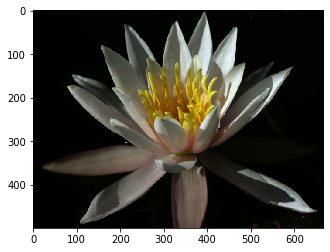

The shape of this image : (500, 667, 3)
The label of this image : 72


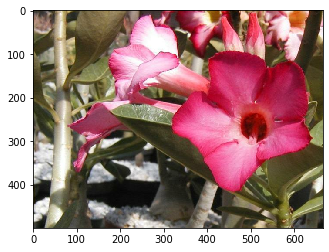

The shape of this image : (500, 666, 3)
The label of this image : 84


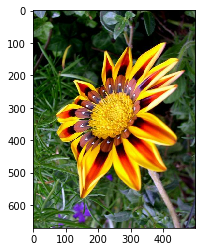

The shape of this image : (670, 500, 3)
The label of this image : 70


In [12]:
# The shape of the images - The label of the images [ 3 labels ] :

for image, label in training_set.take(3):
    image = image.numpy()
    label = label.numpy()
    
    plt.imshow(image)
    plt.show()
    
    print('The shape of this image :' , image.shape)
    print('The label of this image :' , label)

Text(0.5, 1.0, '\n IMAGE LABEL (72) \n')

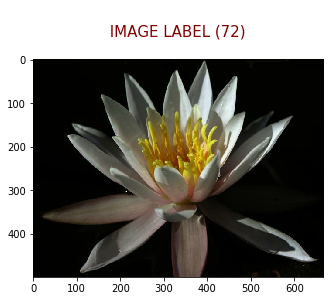

In [19]:
# Take 1 image from Training Set.

for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()
    
    plt.imshow(image)
    
# Show the title of the image.
plt.title('\n IMAGE LABEL ({}) \n'.format(label), color = 'maroon', size = 15 )


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [22]:
# Import JSON.
import json

with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [23]:
# Show the names of the flowers.
class_names

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [27]:
class_names['1'], class_names['102'], class_names['73']

('pink primrose', 'blackberry lily', 'water lily')

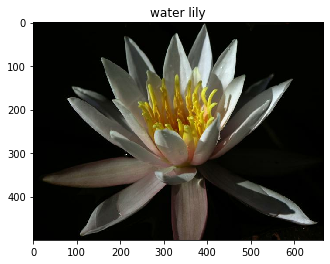

In [29]:
# Take 1 image from Training Set.

for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()
    
# Show the name of the class.    
    plt.imshow(image)
    plt.title(class_names[str(label+1)])

# Create Pipeline

In [32]:
batch_size = 32
image_size = 224
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

In [33]:
# Preparing the Training, Validation, Testing Batches.

# TESTING BATCH :-
testing_batches = test_set.cache().map(format_image).batch(batch_size).prefetch(1)

# VALIDATION BATCH :-
validation_batches = validation_set.cache().map(format_image).batch(batch_size).prefetch(1)

# TRAINING BATCH :-
training_batches = training_set.cache().shuffle(metadata.splits['train'].num_examples//4).map(format_image).batch(batch_size).prefetch(1)


# Building and Train the Classifier

In [34]:
# TODO: Build and train your network

# Classifier URL.
classifier_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

# Keras Layer.
feature_extractor = hub.KerasLayer(classifier_url, input_shape = (image_size, image_size, 3))

# Halt the pre_trained model.
feature_extractor.trainable = False

# Change the final Layer.
classifier = tf.keras.Sequential([feature_extractor, tf.keras.layers.Dense(102, activation = 'softmax')])

In [35]:
# The summary of the model.
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
# Configure the model for Training.
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Stop training when there is no 'Improvement'.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

# Train the model.
history = classifier.fit(training_batches, epochs = 5 , validation_data = validation_batches, callbacks = [early_stopping])

Epoch 1/5
32/32 [==============================] - 103s 3s/step - loss: 4.2702 - accuracy: 0.1186 - val_loss: 3.1186 - val_accuracy: 0.3706
Epoch 2/5
32/32 [==============================] - 93s 3s/step - loss: 2.0754 - accuracy: 0.6794 - val_loss: 2.0037 - val_accuracy: 0.6353
Epoch 3/5
32/32 [==============================] - 93s 3s/step - loss: 1.0870 - accuracy: 0.9059 - val_loss: 1.5395 - val_accuracy: 0.7333
Epoch 4/5
32/32 [==============================] - 94s 3s/step - loss: 0.6715 - accuracy: 0.9608 - val_loss: 1.2915 - val_accuracy: 0.7696
Epoch 5/5
32/32 [==============================] - 94s 3s/step - loss: 0.4467 - accuracy: 0.9873 - val_loss: 1.1519 - val_accuracy: 0.7882


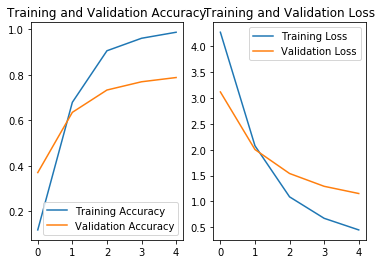

In [41]:
# The Loss and Accuracy achieved.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(5)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.show()

# Testing your Network
It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [45]:
# Print the Loss and Accuracy achieved.
loss, accuracy = classifier.evaluate(testing_batches)
print('\nLoss on the TEST SET : {:,.3f}'.format(loss))
print('Accuracy on the TEST SET : {:.3%}'.format(accuracy))

    193/Unknown - 521s 3s/step - loss: 1.2719 - accuracy: 0.7466
Loss on the TEST SET : 1.272
Accuracy on the TEST SET : 74.663%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your modal as a Keras model (i.e save it as an HDF5 file).

In [48]:
# Save the model.
classifier.save('./classifier.h5')

## Load the Keras Model

Load the Keras model you saved above.

In [49]:
# Load the Keras Model.
model_2 = tf.keras.models.load_model('./classifier.h5', custom_objects = {'KerasLayer' : hub.KerasLayer})
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [50]:
# Create the Procces Image.
def process_image(image):
    image = tf.convert_to_tensor(image, dtype = tf.float32)
    img = tf.image.resize(image, (224,224))
    img = img/255
    img = img.numpy()
    return img

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

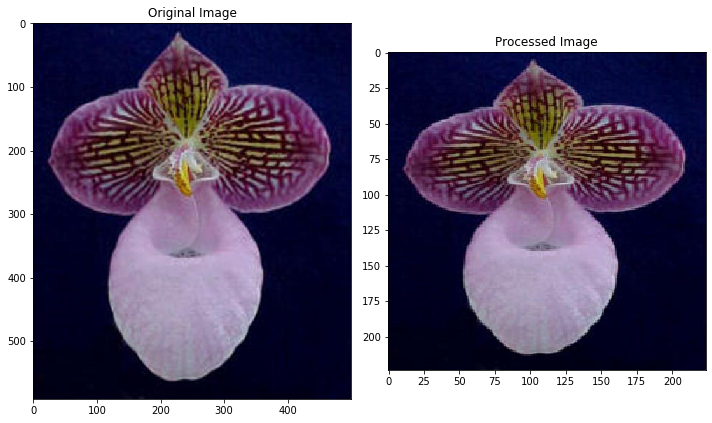

In [54]:
# Import the Image from the Python Imaging Library ( PIL ).
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1,ax2) = plt.subplots(figsize = (10,10), ncols = 2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()


Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [56]:
# Create the Prediction Function.
def predict(image_path, model, top_k):
    img = Image.open(image_path)
    test_img = np.asarray(img)
    trandform_img = process_image(test_img)
    redim_img = np.expand_dims(trandform_img, axis = 0)
    
    prob_pred = model.predict(redim_img)
    prob_pred = prob_pred.tolist()
    probs, classes = tf.math.top_k(prob_pred, k = top_k)
    probs = probs.numpy().tolist()[0]
    classes = classes.numpy().tolist()[0]
    
    return probs, classes

In [58]:
# Print the Probs and Classes.
probs, classes = predict('./test_images/hard-leaved_pocket_orchid.jpg',model_2, 5)
print(' Probs :', probs)
print (' Classes :', classes)

 Probs : [0.970766544342041, 0.007300658617168665, 0.00396637013182044, 0.002798612229526043, 0.0015376501251012087]
 Classes : [1, 67, 79, 5, 6]


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [61]:
# Import the Seaborn library.
import seaborn as sns

[0.970766544342041, 0.007300658617168665, 0.00396637013182044, 0.002798612229526043, 0.0015376501251012087]
[1, 67, 79, 5, 6]
['hard-leaved pocket orchid', 'bearded iris', 'anthurium', 'tiger lily', 'moon orchid']


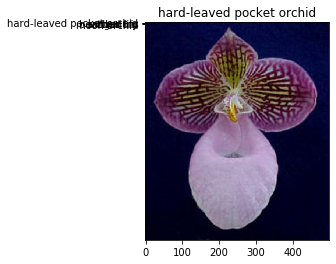

In [62]:
image_path = './test_images/hard-leaved_pocket_orchid.jpg'
image = Image.open(image_path)
test_image = np.asarray(image)
processed_test_image = process_image(test_image)
probs, classes = predict(image_path, model_2, 5)

# Set the labels names.

label_names = [class_names[str(int(idd)+1)] for idd in classes]
print(probs)
print(classes)
print(label_names)



plt.imshow(test_image)
plt.title(label_names[0])
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

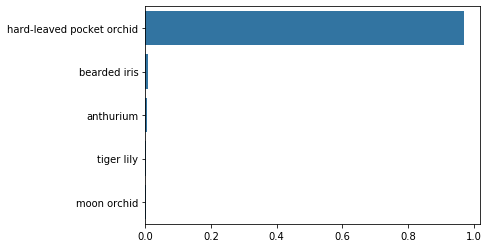

In [63]:
sns.barplot(x = probs, y = label_names, color = sns.color_palette()[0]);
plt.show